# Fitting the TDCOSMO mock data using only quasar position 

Xuheng Ding, 11.03.2020. 
To demonstate the Appdenix B in arXiv:1912.08027.

Perform this notebook requires standard python libraries and the publicly available packages on github:
- lenstronomy (https://github.com/sibirrer/lenstronomy) (pip install lenstronomy)
- fastell4py (only when using the SPEMD model) (https://github.com/sibirrer/fastell4py), based on the original fastell fortran code (by Barkana)

Installation for each package can be found on the github page.
WARNING: a proper installation of fastell4py needs a fortran compiler.

This notebook has been tested with on Python 3.6.10, lenstronomy 1.3.0.

In [1]:
# import the necessary python modules
import numpy as np
import time
import corner

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from lenstronomy.Util import constants
from astropy.cosmology import FlatLambdaCDM
from  lenstronomy.Plots import lens_plot
import glob
import matplotlib.pyplot as plt
import pickle


#Define a calculator to quickly estiamte the time delay distance and H0.
def cal_Ddt(zl, zs, H0_ini=100, om=0.27):
    cosmo = FlatLambdaCDM(H0=H0_ini, Om0=0.27) 
    lensunits=LensCosmo(z_lens=zl, z_source=zs,cosmo= cosmo)
    D_l=lensunits.D_d
    D_s=lensunits.D_s
    D_ls=lensunits.D_ds 
    Ddt_corr = (1+zl)*D_l*D_s/D_ls
    return Ddt_corr

def cal_h0(zl, zs, Ddt, om=0.27):
    Ddt_corr = cal_Ddt(zl, zs, H0_ini=100)
    ratio = Ddt_corr/Ddt
    return 100 * ratio

In [2]:
# Setting the steps for the MCMC
H0_true = 70.65595   # The true H0 value assumed in the simulation.
fix_gamma = False  # Not fix gamma, i.e., testing SPEMD model. If true, SIE will be adopted.

#The true parameters from the simulation for the #ID 1 
z_lens ,z_source = [0.640, 2.408]
ximg = [0.41530, 0.17330, 1.22509, -1.18836]  # image positions in relative RA (arc seconds)
yimg = [-1.19026, 1.24663, 0.14337, -0.11013]  # image positions in relative DEC (arc seconds)
d_dt_sigma = np.array([0.250, 0.250, 0.250])  # 1-sigma uncertainties in the time-delay measurement (in units of days)
d_dt_measured = [0.25322, 4.15310, 8.87434]
D_dt_true = 3898
kwargs_lens_list = [{'theta_E': 1.23651, 'center_x': 0, 'center_y': 0, 'e1': 0.05207, 'gamma': 2.00000, 'e2': 0.01075}]
e1, e2 = kwargs_lens_list[0]['e1'], kwargs_lens_list[0]['e2']

astrometry_sigma = 0.004  # 1-sigma astrometric uncertainties of the image positions
ximg_measured = ximg     #Assumed the measured quasar position are the true value.
yimg_measured = yimg     
kwargs_data_joint = {'time_delays_measured': d_dt_measured,
                     'time_delays_uncertainties': d_dt_sigma,
                     'ra_image_list': [ximg_measured], 'dec_image_list': [yimg_measured]}

In [3]:
#Setting up the model choices:
lens_model_list = ['SPEMD']
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []
# SPEMD parameters
if fix_gamma:
    fixed_lens.append({'gamma': 2.0})  #fix the slope to its true value.
else:
    fixed_lens.append({})

# initial parameter guess
#kwargs_lens_init.append(kwargs_lens[0])
kwargs_lens_init.append({'theta_E': 1.20, 'gamma': 2., 'center_x': 0, 'center_y': 0, 'e1': e1, 'e2': e2})
kwargs_lens_sigma.append({'theta_E': .1, 'e1': 0.1, 'e2': 0.1, 'gamma': 0.1, 'center_x': 0.005, 'center_y': 0.005}) #previous: 'center_x': 0.1, 'center_y': 0.1
kwargs_lower_lens.append({'theta_E': 0.01, 'e1': -0.5, 'e2': -0.5, 'gamma': 1.0, 'center_x': 0-0.01, 'center_y': 0-0.01})
kwargs_upper_lens.append({'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 'gamma': 3.0, 'center_x': 0+0.01, 'center_y': 0+0.01})

# combine all parameter options for lenstronomy
lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]

# =========================
# image position parameters
# =========================
# we chose to model the image positions in the lensed plane (we know where they appear)
point_source_list = ['LENSED_POSITION']
# We fix the image position coordinates.
fixed_ps = [{}]  # we fix the image position coordinates
# these lines below actually don't matter when you keep the image position fixed
kwargs_ps_init = [{'ra_image': ximg_measured, 'dec_image': yimg_measured}] # the initial guess for the appearing image positions is: at the image position.
kwargs_ps_sigma = [{'ra_image': 0.01 * np.ones(len(ximg)), 'dec_image': 0.01 * np.ones(len(ximg))}]
kwargs_lower_ps = [{'ra_image': -10 * np.ones(len(ximg)), 'dec_image': -10 * np.ones(len(ximg))}]
kwargs_upper_ps = [{'ra_image': 10* np.ones(len(ximg)), 'dec_image': 10 * np.ones(len(ximg))}]

# combine all parameter options for lenstronomy
ps_params = [kwargs_ps_init, kwargs_ps_sigma, fixed_ps, kwargs_lower_ps, kwargs_upper_ps]

fixed_special = {}
kwargs_special_init = {}
kwargs_special_sigma = {}
kwargs_lower_special = {}
kwargs_upper_special = {}
# ===================
# Time-delay distance
# ===================
# with time-delay information, we can measure the time-delay distance (units physical Mpc)
# if you want to fix the cosmology and instead use the time-delay information to constrain the lens model, out-comment the line below
kwargs_special_init['D_dt'] = D_dt_true
kwargs_special_sigma['D_dt'] = 1000
kwargs_lower_special['D_dt'] = 0
kwargs_upper_special['D_dt'] = 20000    

special_params = [kwargs_special_init, kwargs_special_sigma, fixed_special, kwargs_lower_special, kwargs_upper_special]

# combined parameter settings
kwargs_params = {'lens_model': lens_params,
                'point_source_model': ps_params,
                'special': special_params}

# our model choices
kwargs_model = {'lens_model_list': lens_model_list, 
                'point_source_model_list': point_source_list
                 }

time_delay_likelihood = True  # bool, set this True or False depending on whether time-delay information is available and you want to make use of its information content.
image_position_likelihood = True  # bool, evaluating the image position likelihood (in combination with astrometric errors)

kwargs_constraints = {'num_point_source_list': [len(ximg)],  
                      'solver_type': 'NONE',  # 'PROFILE_SHEAR', 'NONE', # any proposed lens model must satisfy the image positions appearing at the position of the point sources being sampeld
                      'Ddt_sampling': time_delay_likelihood,  # sampling of the time-delay distance                      
                     }

kwargs_likelihood = {  
                     'image_position_uncertainty': astrometry_sigma,  # astrometric uncertainty of image positions
                     'source_position_likelihood': True,  # evaluates how close the different image positions match the source positons
                     'image_position_likelihood': True, # evaluate point source likelihood given the measured image positions
                     'time_delay_likelihood': time_delay_likelihood,  # evaluating the time-delay likelihood
                     'check_matched_source_position': True, # check non-linear solver and disgard non-solutions
                     'source_position_tolerance': 0.01,
                     'check_bounds': True,  # check parameter bounds and punish them
                     'source_position_sigma': 0.001
                    }
from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 300, 'n_iterations': 300}],
                       ['PSO', {'sigma_scale': 1., 'n_particles': 300, 'n_iterations': 200}],
                       ['PSO', {'sigma_scale': 1., 'n_particles': 300, 'n_iterations': 200}]]

start_time = time.time()
chain_list_pso = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
end_time = time.time()
print(end_time - start_time, 'total time needed for computation')
print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')

#%%
kwargs_result = fitting_seq.best_fit(bijective=True)

#Now plot the convergence of the PSO parameters.
from lenstronomy.Plots import chain_plot as chain_plot
for i in range(len(chain_list_pso)):
    chain_plot.plot_chain_list(chain_list_pso, i)
    plt.show()


Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250


KeyboardInterrupt: 

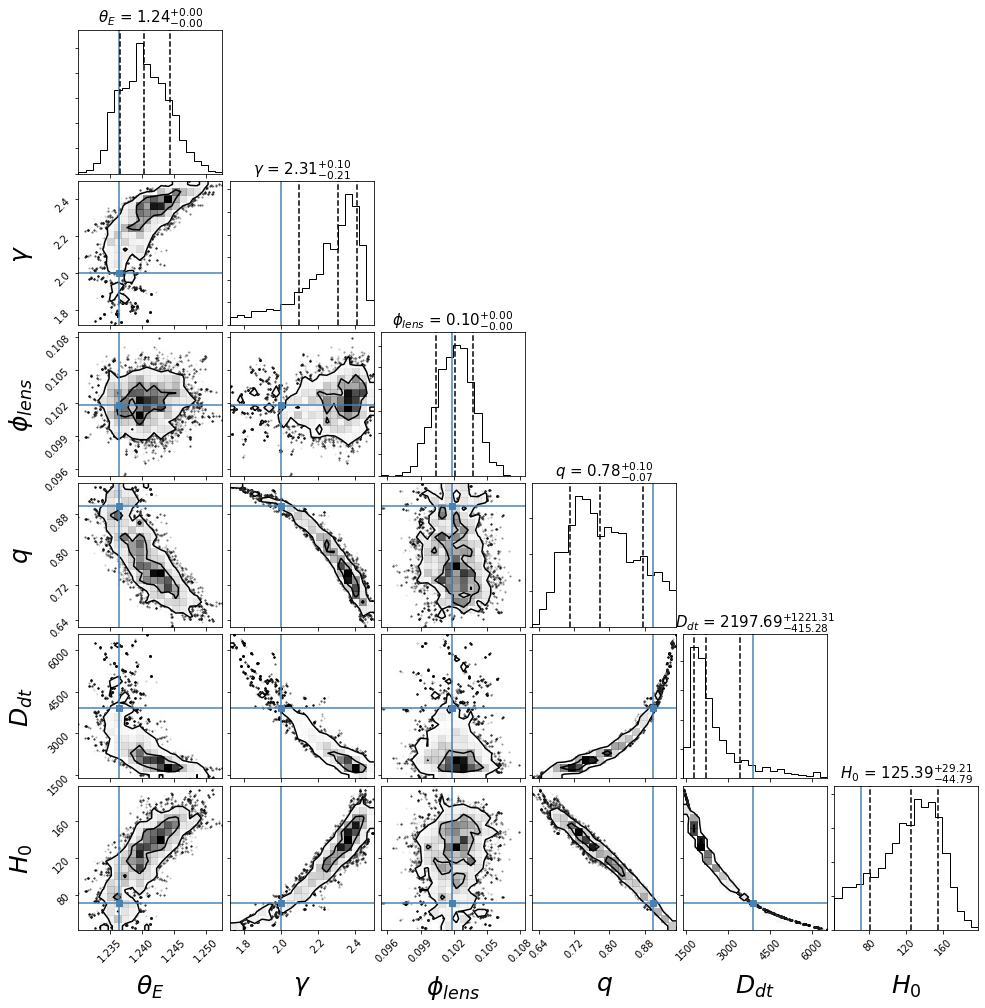

In [6]:
#We run the MCMC to estimate the uncertainty and draw the corner plot.
steps = [1000, 10000]  #1000 as burn steps and 10000 as runing steps for the MCMC.
fitting_kwargs_list = [
    ['MCMC', {'n_burn': steps[0], 'n_run': steps[1], 'walkerRatio': 30,'sigma_scale': 0.1}]
]
chain_list_mcmc = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()    

args_result = fitting_seq.param_class.kwargs2args(**kwargs_result)
logL = fitting_seq.likelihoodModule.logL(args_result, verbose=True)

sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list_mcmc[0]

# import the parameter handling class #
from lenstronomy.Sampling.parameters import Param
import lenstronomy.Util.param_util as param_util
param = Param(kwargs_model, fixed_lens, kwargs_fixed_ps=fixed_ps, kwargs_fixed_special=fixed_special, 
              kwargs_lens_init=kwargs_result['kwargs_lens'], **kwargs_constraints)
# the number of non-linear parameters and their names #
num_param, param_list = param.num_param()

lensModel = LensModel(kwargs_model['lens_model_list'])
lensModelExtensions = LensModelExtensions(lensModel=lensModel) 

mcmc_new_list = []
if fix_gamma:
    labels_new = [r"$\theta_E$", r"$\phi_{lens}$", r"$q$",r"$D_{dt}$", r"$H_0$"]
else:
    labels_new = [r"$\theta_E$", r"$\gamma$", r"$\phi_{lens}$", r"$q$",r"$D_{dt}$", r"$H_0$"]

#        for i in range(len(samples_mcmc)):
trans_steps = int(np.min([len(samples_mcmc)/10, 40000]))
for i in range(trans_steps):
    # transform the parameter position of the MCMC chain in a lenstronomy convention with keyword arguments #
    kwargs_out = param.args2kwargs(samples_mcmc[-trans_steps+i])
    kwargs_lens_out, kwargs_special_out, kwargs_ps_out = kwargs_out['kwargs_lens'], kwargs_out['kwargs_special'], kwargs_out['kwargs_ps']

    # compute 'real' image position adding potential astrometric shifts
    x_pos, y_pos = kwargs_ps_out[0]['ra_image'], kwargs_ps_out[0]['dec_image']

    # extract quantities of the main deflector
    theta_E = kwargs_lens_out[0]['theta_E']
    e1, e2 = kwargs_lens_out[0]['e1'], kwargs_lens_out[0]['e2']
    phi, q = param_util.ellipticity2phi_q(e1, e2)
    if fix_gamma:
        new_chain = [theta_E, phi, q]
    else:
        gamma = kwargs_lens_out[0]['gamma']
        new_chain = [theta_E, gamma, phi, q]
    D_dt = kwargs_special_out['D_dt']
    new_chain.append(D_dt)
    new_chain.append(cal_h0(z_lens ,z_source, D_dt))
    #source_size = np.random.uniform(high=1, low=0)
    mcmc_new_list.append(np.array(new_chain))
    if int(i/2000) > int((i-1)/2000) :
        print("total",len(samples_mcmc), "finished translate:", i)

kwargs_lens_list = [{'theta_E': 1.23651, 'center_x': 0, 'center_y': 0, 'e1': 0.05207, 'gamma': 2.00000, 'e2': 0.01075}]

phi, q = param_util.ellipticity2phi_q(kwargs_lens_list[0]['e1'], kwargs_lens_list[0]['e2'])

if fix_gamma:
    truths=[kwargs_lens_list[0]['theta_E'], phi, q, D_dt_true, H0_true]
elif fix_gamma == False:
    truths=[kwargs_lens_list[0]['theta_E'], 2.0, phi,  q, D_dt_true, H0_true]

plot = corner.corner(mcmc_new_list, labels=labels_new, show_titles=True,
                     quantiles=[0.16, 0.5, 0.84], truths =truths,
                     title_kwargs={"fontsize": 15}, label_kwargs = {"fontsize": 25},
                     levels=1.0 - np.exp(-0.5 * np.array([1.,2.]) ** 2))
plt.show()